In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import PowerTransformer
import shap


In [2]:
data = pd.read_csv("G:\\23881A66E2\\Projects\\Customer_Churn_Predictor\\data\\WA_Fn-UseC_-Telco-Customer-Churn.csv")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
data = data.drop(['customerID', 'gender'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


Numeric Columns:  
tenure (int)  
MonthlyCharges (float)  
TotalCharges (float)  
  
  
Binary Categorical:  
SeniorCitizen  
Partner  
Dependents  
PhoneService  
PaperlessBilling  
  
  
Multi-class Categorical:  
MultipleLines  
InternetService  
OnlineSecurity  
OnlineBackup  
DeviceProtection  
TechSupport  
StreamingTV  
StreamingMovies  
Contract  
PaymentMethod  
  
  
Target: Churn  

Correlation Finding

In [7]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

In [8]:
data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13476\2578155999.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})


In [9]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

binary_cat_cols = [
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
]

binary_numeric_cols = ["SeniorCitizen"]

multi_cat_cols = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

target_col = "Churn"

print("Numeric:", numeric_cols + binary_numeric_cols)
print("Binary cats:", binary_cat_cols)
print("Multi cats:", multi_cat_cols)

Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Binary cats: ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
Multi cats: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [10]:
#numeric to numeric 
#pearson (linear relationships)
pearson_corr = data[numeric_cols + binary_numeric_cols].corr(method='pearson')
print(f"Pearson Correlation:\n{pearson_corr}")

Pearson Correlation:
                  tenure  MonthlyCharges  TotalCharges  SeniorCitizen
tenure          1.000000        0.247900      0.825880       0.016567
MonthlyCharges  0.247900        1.000000      0.651065       0.220173
TotalCharges    0.825880        0.651065      1.000000       0.102411
SeniorCitizen   0.016567        0.220173      0.102411       1.000000


In [11]:
#spearman (monotonic relationships)
spearman_corr = data[numeric_cols + binary_numeric_cols].corr(method='spearman')
print(f"Spearman Correlation:\n{spearman_corr}")

Spearman Correlation:
                  tenure  MonthlyCharges  TotalCharges  SeniorCitizen
tenure          1.000000        0.276417      0.889177       0.018556
MonthlyCharges  0.276417        1.000000      0.638032       0.221067
TotalCharges    0.889177        0.638032      1.000000       0.107248
SeniorCitizen   0.018556        0.221067      0.107248       1.000000


In [12]:
# numeric to churn

def compute_point_biserial(data, num_cols, target_col):
    pb_results = {}
    for col in num_cols:
        corr, p_value = pointbiserialr(data[col], data[target_col])
        pb_results[col] = {"correlation": corr, "p_value": p_value}
    return pd.DataFrame(pb_results).T 

pb_results = compute_point_biserial(data, numeric_cols + binary_numeric_cols, target_col)
print("\nPoint-Biserial Correlation with Churn:")
print(pb_results)


Point-Biserial Correlation with Churn:
                correlation        p_value
tenure            -0.352229  7.999058e-205
MonthlyCharges     0.193356   2.706646e-60
TotalCharges            NaN            NaN
SeniorCitizen      0.150889   3.839860e-37


In [13]:
# Catergorical to Churn

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

def chi2_cramers_v(data, cat_cols, target):
    cramers_results = {}
    for col in cat_cols:
        confusion_mat = pd.crosstab(data[col], data[target])
        cv = cramers_v(confusion_mat)
        cramers_results[col] = cv
    return pd.Series(cramers_results).sort_values(ascending=False)

cat_cols_for_churn = binary_cat_cols + multi_cat_cols
chi_cramers_results = chi2_cramers_v(data, cat_cols_for_churn, target_col)

print("Chi-square & Cramer's V with Churn:")
print(chi_cramers_results)

Chi-square & Cramer's V with Churn:
Contract            0.410116
OnlineSecurity      0.347400
TechSupport         0.342916
InternetService     0.322455
PaymentMethod       0.303359
OnlineBackup        0.292316
DeviceProtection    0.281580
StreamingMovies     0.230951
StreamingTV         0.230502
PaperlessBilling    0.191498
Dependents          0.163870
Partner             0.150126
MultipleLines       0.040109
PhoneService        0.011398
dtype: float64


In [14]:
service_cols = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

data["TotalServices"] = (data[service_cols] == "Yes").sum(axis=1)

# IsFiberCustomer: Fiber optic = 1, else 0
data["IsFiberCustomer"] = (data["InternetService"] == "Fiber optic").astype(int)

# IsMonthToMonth: month-to-month contract = 1, else 0
data["IsMonthToMonth"] = (data["Contract"] == "Month-to-month").astype(int)

# TechIssueRisk: has internet but no tech support
data["TechIssueRisk"] = ((data["InternetService"] != "No") & (data["TechSupport"] == "No")).astype(int)

# TenureGroup: bins for tenure
tenure_bins = [0, 6, 12, 24, 48, data["tenure"].max()]
tenure_labels = ["0-6", "6-12", "12-24", "24-48", "48+"]

data["TenureGroup"] = pd.cut(
    data["tenure"],
    bins=tenure_bins,
    labels=tenure_labels,
    right=True,
    include_lowest=True,
)

# PaymentRisk: electronic check = 1, else 0
data["PaymentRisk"] = (data["PaymentMethod"] == "Electronic check").astype(int)

# HasPhoneAndInternet: both phone and some internet
data["HasPhoneAndInternet"] = (
    (data["PhoneService"] == "Yes") & (data["InternetService"] != "No")
).astype(int)

print("\n=== Sample of engineered features ===")
print(data[[
    "tenure", "MonthlyCharges", "TotalCharges", "Contract", "InternetService",
    "TechSupport", "PaymentMethod", "TotalServices", "IsFiberCustomer",
    "IsMonthToMonth", "TechIssueRisk", "TenureGroup", "PaymentRisk",
    "HasPhoneAndInternet", "Churn"
]].head())


=== Sample of engineered features ===
   tenure  MonthlyCharges  TotalCharges        Contract InternetService  \
0       1           29.85         29.85  Month-to-month             DSL   
1      34           56.95       1889.50        One year             DSL   
2       2           53.85        108.15  Month-to-month             DSL   
3      45           42.30       1840.75        One year             DSL   
4       2           70.70        151.65  Month-to-month     Fiber optic   

  TechSupport              PaymentMethod  TotalServices  IsFiberCustomer  \
0          No           Electronic check              1                0   
1          No               Mailed check              2                0   
2          No               Mailed check              2                0   
3         Yes  Bank transfer (automatic)              3                0   
4          No           Electronic check              0                1   

   IsMonthToMonth  TechIssueRisk TenureGroup  Payment

In [15]:
# Correlation of engineered features with churn

eng_num_cols = [
    "TotalServices",
    "IsFiberCustomer",
    "IsMonthToMonth",
    "TechIssueRisk",
    "PaymentRisk",
    "HasPhoneAndInternet",
]

pb_eng = compute_point_biserial(data, eng_num_cols, target_col)
print("\nPoint-Biserial: Engineered Features vs Churn:")
print(pb_eng.sort_values(by="correlation", ascending=False))


Point-Biserial: Engineered Features vs Churn:
                     correlation        p_value
IsMonthToMonth          0.405103  1.991701e-276
TechIssueRisk           0.337281  6.413692e-187
IsFiberCustomer         0.308020  1.200784e-154
PaymentRisk             0.301919  2.296890e-148
HasPhoneAndInternet     0.209988   5.068795e-71
TotalServices          -0.087698   1.671374e-13


In [16]:
data

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,TotalServices,IsFiberCustomer,IsMonthToMonth,TechIssueRisk,TenureGroup,PaymentRisk,HasPhoneAndInternet
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,...,29.85,29.85,0,1,0,1,1,0-6,1,0
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,...,56.95,1889.50,0,2,0,0,1,24-48,0,1
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,...,53.85,108.15,1,2,0,1,1,0-6,0,1
3,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,...,42.30,1840.75,0,3,0,0,0,24-48,0,0
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,...,70.70,151.65,1,0,1,1,1,0-6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,...,84.80,1990.50,0,5,0,0,0,12-24,0,1
7039,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,...,103.20,7362.90,0,4,1,0,1,48+,0,1
7040,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,...,29.60,346.45,0,1,0,1,1,6-12,1,0
7041,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,...,74.40,306.60,1,0,1,1,1,0-6,0,1


In [17]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,TotalServices,IsFiberCustomer,IsMonthToMonth,TechIssueRisk,PaymentRisk,HasPhoneAndInternet
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370,2.037910,0.439585,0.550192,0.493114,0.335794,0.686497
std,0.368612,24.559481,30.090047,2266.771362,0.441561,1.847682,0.496372,0.497510,0.499988,0.472301,0.463950
min,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Final feature calssified according to their types for catboost model

numeric_cols = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "SeniorCitizen",
    "TotalServices",
    "IsFiberCustomer",
    "IsMonthToMonth",
    "TechIssueRisk",
    "PaymentRisk",
    "HasPhoneAndInternet",
]

cat_cols = [
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "TenureGroup",
]

target_col = "Churn"

all_features = numeric_cols + cat_cols

print("New classification of features for catboost model:")
print("Numeric:", numeric_cols)
print("Categorical:", cat_cols)
print("Target:", target_col)

New classification of features for catboost model:
Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'TotalServices', 'IsFiberCustomer', 'IsMonthToMonth', 'TechIssueRisk', 'PaymentRisk', 'HasPhoneAndInternet']
Categorical: ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
Target: Churn


array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>,
        <Axes: title={'center': 'Churn'}>,
        <Axes: title={'center': 'TotalServices'}>],
       [<Axes: title={'center': 'IsFiberCustomer'}>,
        <Axes: title={'center': 'IsMonthToMonth'}>,
        <Axes: title={'center': 'TechIssueRisk'}>],
       [<Axes: title={'center': 'PaymentRisk'}>,
        <Axes: title={'center': 'HasPhoneAndInternet'}>, <Axes: >]],
      dtype=object)

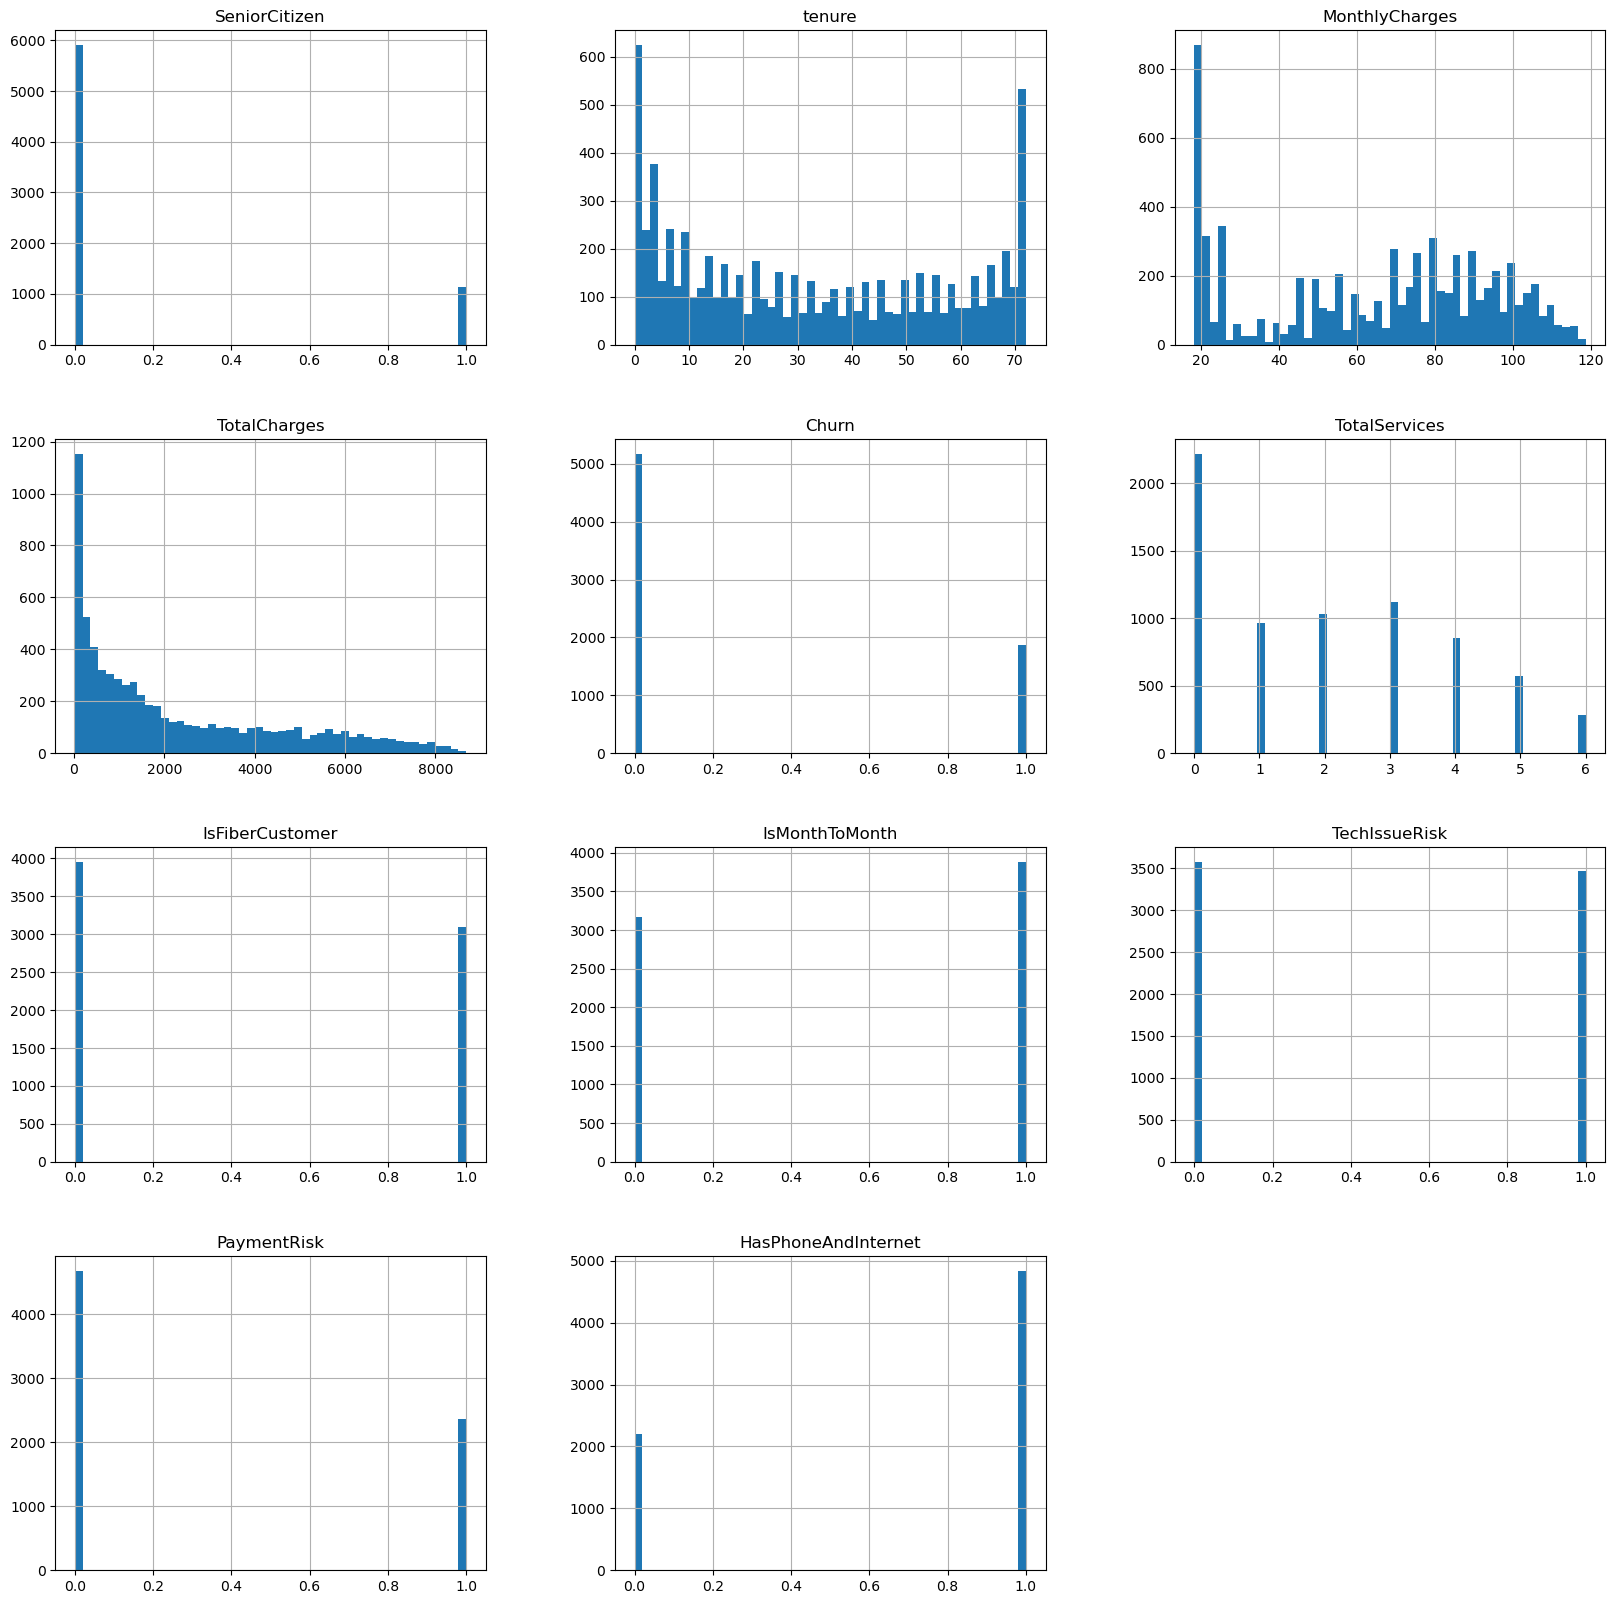

In [19]:
# valid only to tenure, MonthlyCharges, TotalCharges

data.hist(figsize=(20, 20), bins=50)

In [20]:
#value count of each column
for column in data.columns:
    print(data[column].value_counts())
    print("\n")

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype:

In [21]:
x_cat = data[all_features].copy()
y = data[target_col].copy()

x_train, x_test, y_train, y_test = train_test_split(
    x_cat, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
train_pool = Pool(data=x_train, label=y_train, cat_features=cat_cols)

test_pool = Pool(data=x_test, label=y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    task_type='GPU',
    verbose = False,
    plot=True
)

model.fit(
    train_pool, 
    eval_set=test_pool,
    use_best_model=True,    
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225490	best: 0.8225490 (0)	total: 8.68s	remaining: 1h 12m 9s
100:	test: 0.8451743	best: 0.8451743 (100)	total: 12.9s	remaining: 51.2s
200:	test: 0.8455902	best: 0.8456237 (195)	total: 17.2s	remaining: 25.7s
300:	test: 0.8454093	best: 0.8457064 (260)	total: 20.9s	remaining: 13.8s
400:	test: 0.8445969	best: 0.8457064 (260)	total: 24.3s	remaining: 5.99s
499:	test: 0.8443334	best: 0.8457064 (260)	total: 28.1s	remaining: 0us
bestTest = 0.8457064033
bestIteration = 260
Shrink model to first 261 iterations.


In [25]:
y_proba = model.predict_proba(test_pool)[:, 1]
y_pred = model.predict(test_pool)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))

ROC-AUC: 0.8457064248624351

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



Text(0, 0.5, 'True Label')

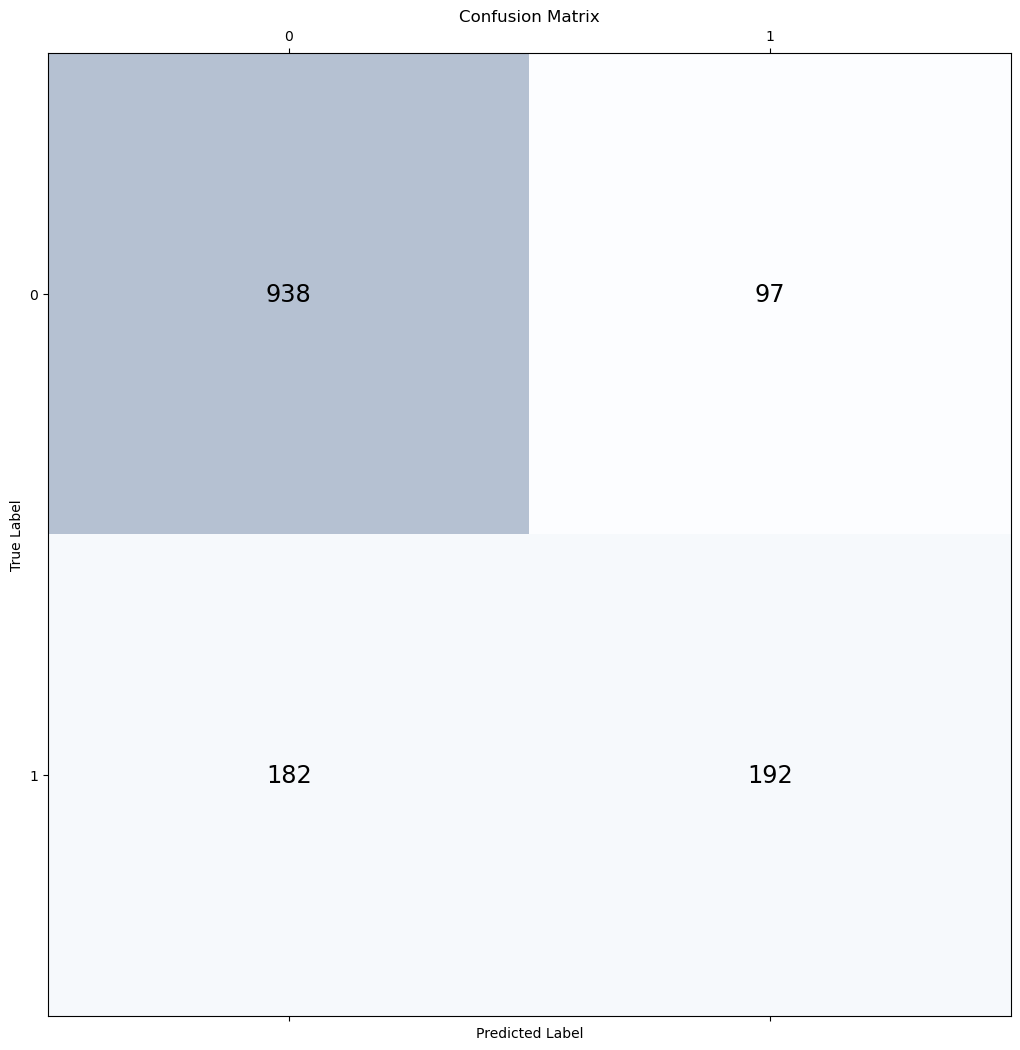

In [26]:
fig, ax = plt.subplots(figsize=(12.5, 12.5))
ax.matshow(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix(y_test, y_pred).shape[0]):
    for j in range(confusion_matrix(y_test, y_pred).shape[1]):
        ax.text(x=j, y=i, s=confusion_matrix(y_test, y_pred)[i, j], va='center', ha='center', size='xx-large')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [27]:
importances = model.get_feature_importance(train_pool, type="PredictionValuesChange")
feat_importance = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance)

                feature  importance
0                tenure   20.331566
6        IsMonthToMonth   15.720672
1        MonthlyCharges   11.094194
2          TotalCharges    9.375991
5       IsFiberCustomer    9.156865
21             Contract    8.126548
7         TechIssueRisk    4.559706
15       OnlineSecurity    4.122792
8           PaymentRisk    3.311388
22     PaperlessBilling    2.749021
13        MultipleLines    2.516769
14      InternetService    1.330659
20      StreamingMovies    0.953456
19          StreamingTV    0.943843
17     DeviceProtection    0.898215
16         OnlineBackup    0.780865
4         TotalServices    0.672591
18          TechSupport    0.665652
11           Dependents    0.634851
24          TenureGroup    0.500299
12         PhoneService    0.454894
9   HasPhoneAndInternet    0.406370
3         SeniorCitizen    0.324653
23        PaymentMethod    0.321603
10              Partner    0.046536


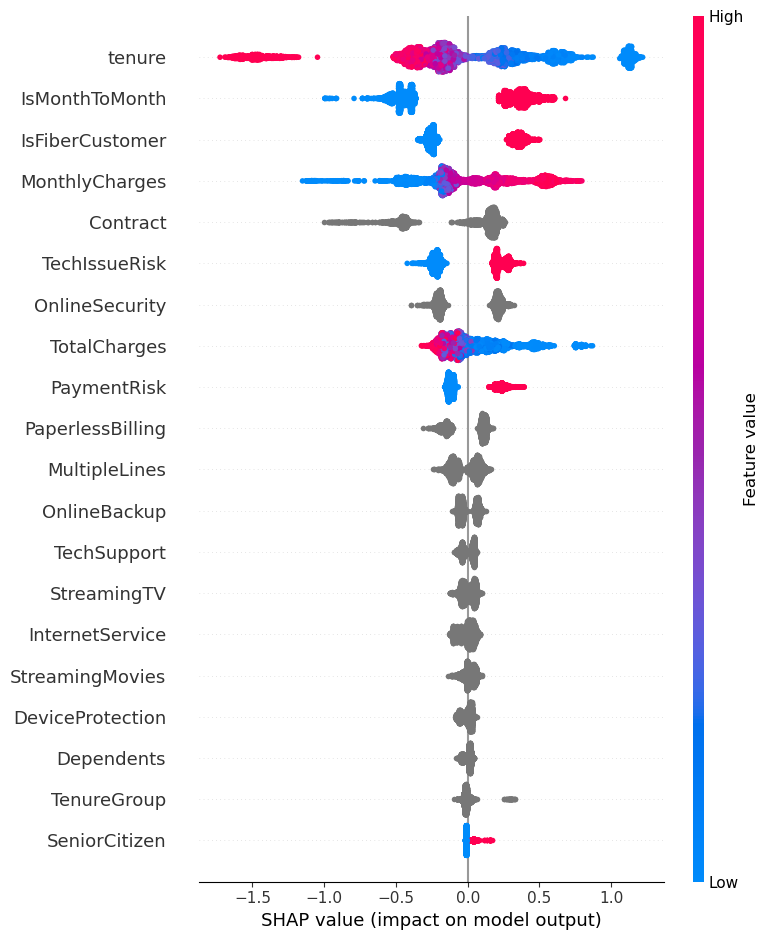

In [28]:
shap_values = model.get_feature_importance(
    train_pool,
    type="ShapValues"
)

# shap_values shape: (n_samples, n_features + 1)
# last column is expected value (base value)
shap_values_features = shap_values[:, :-1]

# If you want a summary plot (needs shap library)
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap.summary_plot(shap_values_features, x_train, feature_names=all_features)


In [29]:
param_grid = {
    "depth": [4, 5, 6, 8],
    "learning_rate": [0.1, 0.05, 0.03, 0.01],
    "l2_leaf_reg": [1, 3, 5, 7, 10],
    "bagging_temperature": [0, 0.5, 1],
}

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose = False,
    plot=True
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid_search.fit(x_train, y_train, cat_features=cat_cols)

print("Best params:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_proba = best_model.predict_proba(x_test)[:, 1]
y_pred = best_model.predict(x_test)

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report on test:\n", classification_report(y_test, y_pred))

0:	total: 17.6ms	remaining: 8.78s
100:	total: 1.8s	remaining: 7.13s
200:	total: 3.48s	remaining: 5.18s
300:	total: 5.1s	remaining: 3.37s
400:	total: 6.79s	remaining: 1.68s
499:	total: 8.46s	remaining: 0us
Best params: {'bagging_temperature': 0, 'depth': 4, 'l2_leaf_reg': 10, 'learning_rate': 0.03}
Best CV AUC: 0.8500643047064859
Test ROC-AUC: 0.8467656100648429

Classification report on test:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [23]:
final_model = CatBoostClassifier(
    depth=4,
    learning_rate=0.03,
    l2_leaf_reg=10,
    bagging_temperature=0,
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=100,
    class_weights={0: 1.0, 1: (y_train == 0).sum() / (y_train == 1).sum()},
    random_seed=42,
    verbose = False,
    task_type='GPU',
)

final_model.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    cat_features=cat_cols,
    use_best_model=True,
)

Default metric period is 5 because AUC is/are not implemented for GPU


In [24]:
importances = final_model.get_feature_importance(train_pool, type="PredictionValuesChange")
feat_importance = pd.DataFrame({
    "feature": x_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance)


                feature  importance
6        IsMonthToMonth   20.860837
0                tenure   19.614469
1        MonthlyCharges   10.436415
5       IsFiberCustomer    8.972534
2          TotalCharges    7.535887
21             Contract    6.842830
15       OnlineSecurity    5.406572
7         TechIssueRisk    4.767144
8           PaymentRisk    3.741287
22     PaperlessBilling    2.312651
14      InternetService    2.302598
13        MultipleLines    1.530977
20      StreamingMovies    0.973167
24          TenureGroup    0.791811
16         OnlineBackup    0.681377
9   HasPhoneAndInternet    0.661340
19          StreamingTV    0.658895
11           Dependents    0.427745
4         TotalServices    0.338737
12         PhoneService    0.327671
18          TechSupport    0.298500
3         SeniorCitizen    0.270406
23        PaymentMethod    0.183126
17     DeviceProtection    0.059869
10              Partner    0.003154


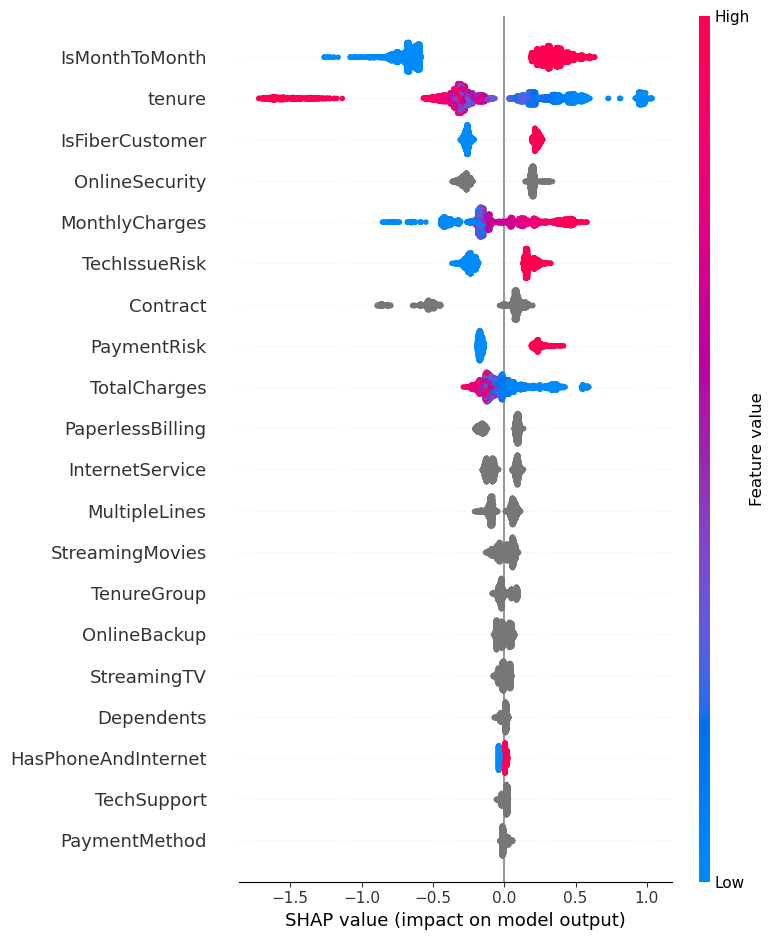

In [25]:
shap_values = final_model.get_feature_importance(train_pool, type="ShapValues")
shap_values_features = shap_values[:, :-1]  # drop expected value column

shap.initjs()
shap.summary_plot(shap_values_features, x_train, feature_names=x_train.columns)

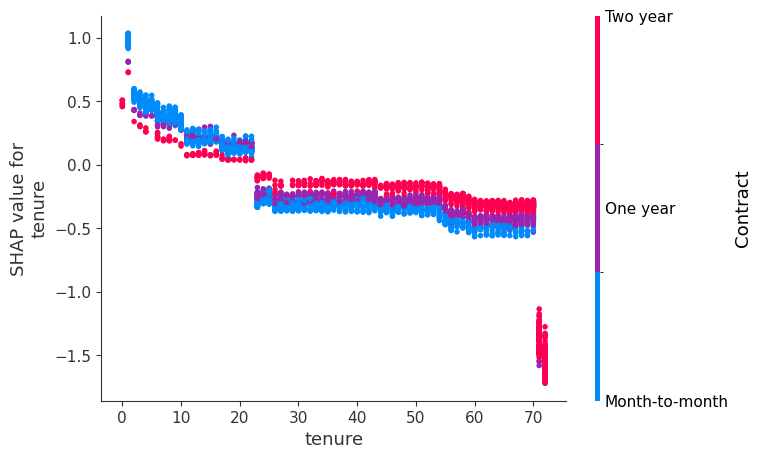

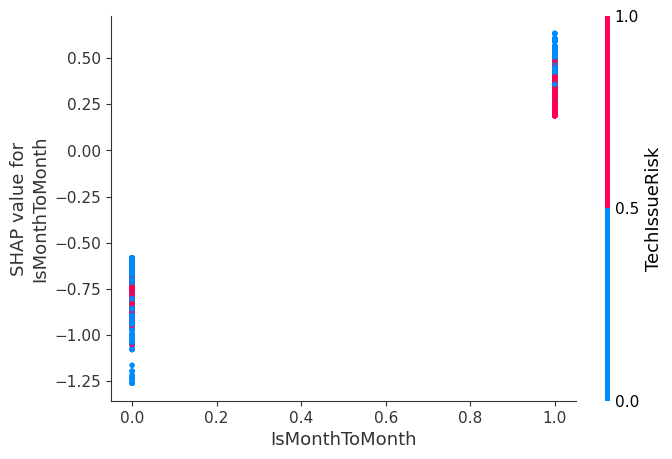

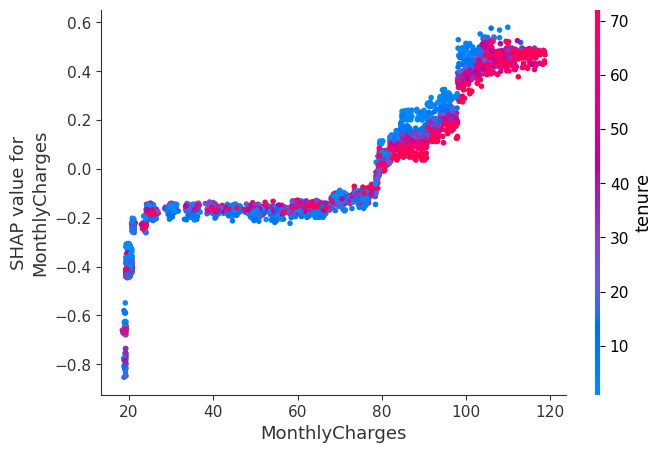

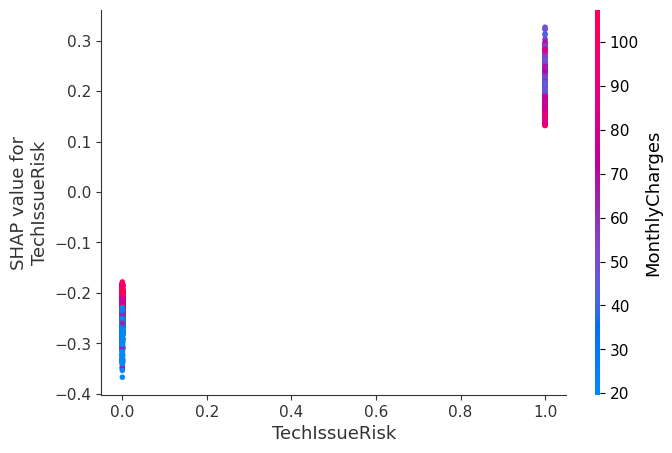

In [26]:
# Tenure effect
shap.dependence_plot("tenure", shap_values_features, x_train, feature_names=x_train.columns)

# IsMonthToMonth effect
shap.dependence_plot("IsMonthToMonth", shap_values_features, x_train, feature_names=x_train.columns)

# MonthlyCharges
shap.dependence_plot("MonthlyCharges", shap_values_features, x_train, feature_names=x_train.columns)

# TechIssueRisk
shap.dependence_plot("TechIssueRisk", shap_values_features, x_train, feature_names=x_train.columns)


In [27]:
seg1 = data[data["tenure"] <= 6]
seg2 = data[(data["IsMonthToMonth"] == 1) & (data["IsFiberCustomer"] == 1)]
seg3 = data[data["TechIssueRisk"] == 1]

print("Churn rate - tenure <= 6:", seg1["Churn"].mean())
print("Churn rate - M2M + Fiber:", seg2["Churn"].mean())
print("Churn rate - TechIssueRisk:", seg3["Churn"].mean())


Churn rate - tenure <= 6: 0.5293720459149224
Churn rate - M2M + Fiber: 0.5460526315789473
Churn rate - TechIssueRisk: 0.4163547365390153


In [29]:
final_model.save_model("catboost_churn.cbm")